In [1]:
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
from shapely.geometry import point, Polygon
import rioxarray
from pyproj import CRS
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import requests
from osgeo import gdal
from osgeo import ogr
import fiona
%matplotlib inline
from shapely.geometry import Polygon
import shapefile

from rasterio.mask import mask
import plotly.graph_objects as go

In [2]:
address = 'Stadsplein 2, 2640 Mortsel'
#address = input('Provide a valid address in Flanders: ')
#Heikantstraat 124, 2910 Essen
#Epicealaan 28, 2910 Essen
#Moerkantsebaan 34, 2910 Essen
#Maststraat 2, 2910 Essen

In [3]:
# get a polygoon based on address in Flanders

def get_coordinates(address: str):
    req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()
    info = {'address' : address, 
                'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'y_value' : req['LocationResult'][0]['Location']['Y_Lambert72'],
                'street' : req['LocationResult'][0]['Thoroughfarename'],
                'house_number' : req['LocationResult'][0]['Housenumber'], 
                'postcode': req['LocationResult'][0]['Zipcode'], 
                'municipality' : req['LocationResult'][0]['Municipality']}
    
    detail = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
                          params={"postcode": info['postcode'], 
                                  "straatnaam": info['street'],
                                  "huisnummer": info['house_number']}).json()
    building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
    build = requests.get(building['gebouw']['detail']).json()
    info['polygon'] = [build['geometriePolygoon']['polygon']]
    return info['polygon'][0]['coordinates'][0] 

In [4]:
# store polygon in a variable
polygon = get_coordinates(address)

In [5]:
x_polygon = [i[0] for i in polygon]

In [6]:
y_polygon = [i[1] for i in polygon]

In [7]:
# convert polygon to a Shapely format
polygon_shapely = Polygon(polygon)
polygon_shapely.buffer(2.0)

# save a polygon to a .shp file
w = shapefile.Writer('shapefiles/polygon')
w.field('name', 'C')

w.poly([polygon])
w.record('polygon1')

w.close()

In [8]:
polygon_shapely.area

134.36859495742723

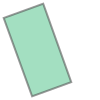

In [9]:
polygon_shapely

In [10]:
polygon_path = 'C:/Users/kasia/pyproj/3D_houses/shapefiles/polygon.shp'

In [11]:
# calculate bounds of a rectangle that contains the polygon
left = min(x_polygon)
right = max(x_polygon)
top = max(y_polygon)
bottom = min(y_polygon)
# print(f"left = {left}, right = {right}, top = {top}, bottom = {bottom}")

In [12]:
# create a rectangle which contains the polygoon (left,bottom, right, top)

In [13]:
polygon_bounds = [[left,bottom, right, top]]
polygon_bounds

[[156122.0249114856,
  206747.62798551098,
  156135.29025549442,
  206765.82113752142]]

In [14]:
# find to which file belong polygon_bounds - loop over the the DTM_bounds.csv

In [15]:
df = pd.read_csv('DTM_bounds.csv')

In [16]:
for index, row in df.iterrows():
    if left >= row.left and right <= row.right and top <= row.top and bottom >= row.bottom:
        right_dtm_url = row.url_dtm
        right_dsm_url = row.url_dsm
print(right_dsm_url)       
print(right_dtm_url)         

zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k15.zip!/GeoTIFF/DHMVIIDSMRAS1m_k15.tif
zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k15.zip!/GeoTIFF/DHMVIIDTMRAS1m_k15.tif


In [17]:
# clip DSM file with rasterio
with fiona.open("C:/Users/kasia/pyproj/3D_houses/shapefiles/polygon.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(right_dsm_url) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

In [18]:
with rasterio.open("C:/Users/kasia/pyproj/3D_houses/DSM_clip.tif", "w", **out_meta) as dest:
    dest.write(out_image)    

In [19]:
#with rasterio.open("DSM_clip.tif") as src:
#    DSM_clip = src.read(1, masked=True)  
#    src.close()

In [109]:
with rioxarray.open_rasterio("C:/Users/kasia/pyproj/3D_houses/DSM_clip.tif", masked = True) as src:
    DSM_clip = src

In [21]:
# clip DTM file with rasterio
with rasterio.open(right_dtm_url) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})



In [108]:
with rasterio.open("C:/Users/kasia/pyproj/3D_houses/DTM_clip.tif", "w", **out_meta) as dest:
    dest.write(out_image)  

CPLE_AppDefinedError: Deleting C:/Users/kasia/pyproj/3D_houses/DTM_clip.tif failed: Permission denied

In [110]:
with rioxarray.open_rasterio("C:/Users/kasia/pyproj/3D_houses/DTM_clip.tif", masked = True) as src:
    DTM_clip = src

In [24]:
#with rasterio.open("DTM_clip.tif") as src:
#    DTM_clip = src.read(1, masked=True) 
#    src.close()

In [111]:
CHM_clip = DSM_clip - DTM_clip

In [112]:
type(CHM_clip)

xarray.core.dataarray.DataArray

In [113]:
CHM_clip = CHM_clip.fillna(0)

In [99]:
#CHM_clip.compute()

In [87]:
CHM_clip_padded = np.pad(CHM_clip, pad_width=1)

In [105]:
CHM_clip.shape

(1, 19, 14)

In [114]:
CHM_clip = CHM_clip[0]

In [74]:
#CHM_clip.values

In [115]:
#plotly
z = CHM_clip_padded
x, y = np.meshgrid(np.arange(CHM_clip_padded.shape[1],np.arange(CHM_clip_padded.shape[0]))
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='3D House Model', autosize=False)
fig.show()

SyntaxError: invalid syntax (Temp/ipykernel_2064/3200820981.py, line 4)

In [107]:
fig = go.Figure(data=go.Surface (z= CHM_clip , opacity=0.9, colorscale='geyser'))
                  

fig.update_layout(scene = dict(
                    xaxis_title='X AXIS TITLE',
                    yaxis_title='Y AXIS TITLE',
                    zaxis_title='Z AXIS TITLE'),
                    width=700,
                    height = 700
                  )

fig.show()

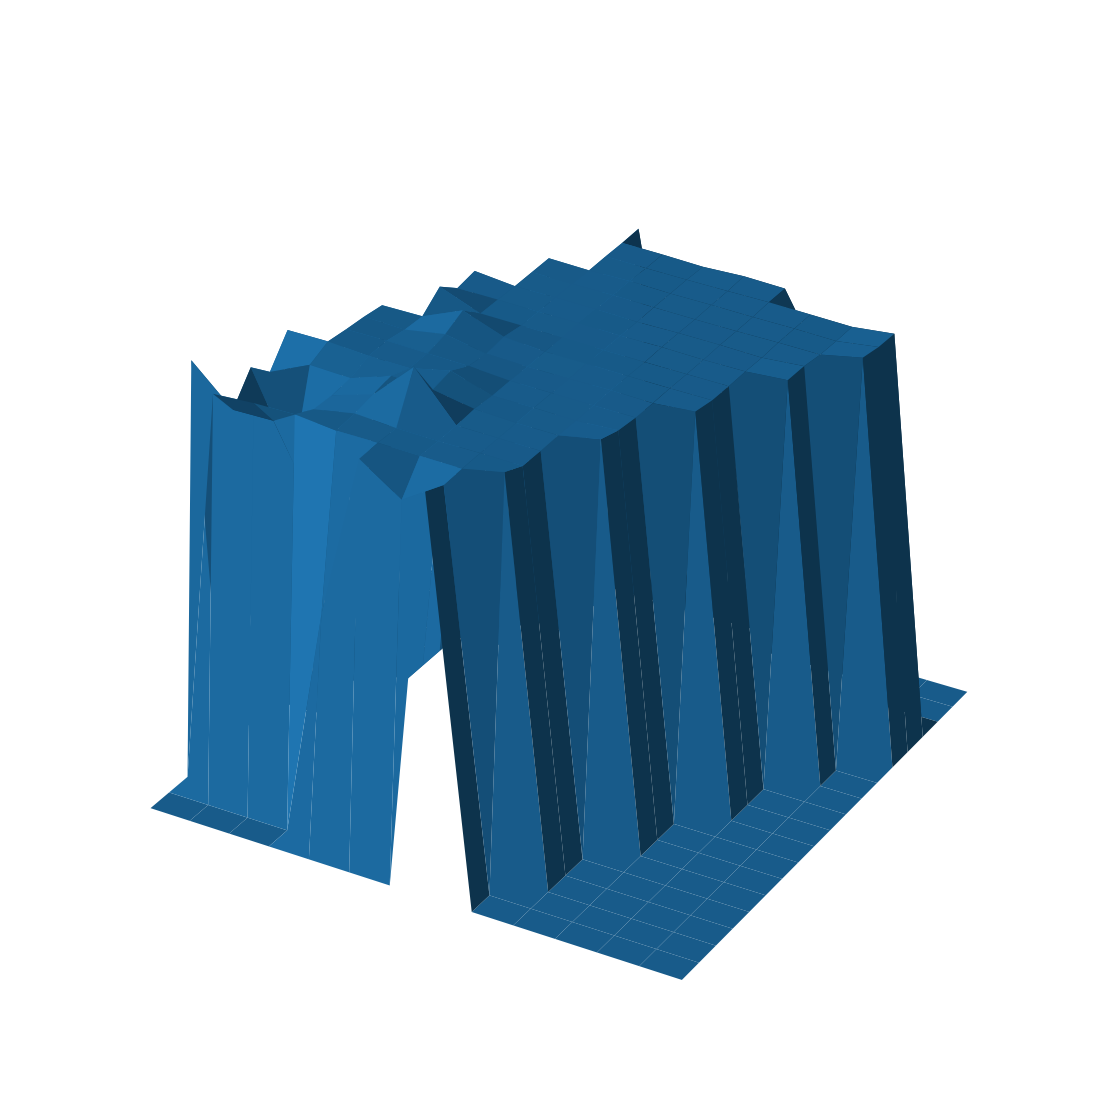

In [77]:
# matplotlib
# initialize figure and axes3D objects
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111, projection='3d')

# plotting the 3D data
X, Y = np.meshgrid(np.arange(CHM_clip.shape[1]), np.arange(CHM_clip.shape[0]))
ax.plot_surface(X, Y, CHM_clip)
plt.xticks(rotation=90)
ax.axis("off")
plt.show()